<a href="https://colab.research.google.com/github/otaviocx/exemplo-gnn-tdc2020/blob/master/Exemplo_Simples_de_GNN_Karate_Club.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exemplo Simples de GNN

No exemplo abaixo serão utilizados os frameworks [PyTorch]() e [DGL]() para criação de uma Rede Neural Convolucional para Grafos, visando a classificação binária no dataset Karate Club Graph. Esse dataset é composto por indivíduos de um clube de caratê que, com o decorrer do tempo, se dividiu em dois grupos: aqueles que seguiam o diretor do clube (*Officer*) e aqueles que seguiam o professor (*Mr. Hi*). A classificação é feita utilizando uma abordagem semi-supervisionada, adicionando rótulos apenas no diretor e no processor.

In [8]:
# DGL não é instalado por padrão no Google Colab, então é necessário instalá-lo
!pip install dgl

     |████████████████████████████████| 3.6MB 2.8MB/s 


In [ ]:
import networkx as nx
import pandas as pd
import torch
import dgl

A função `draw_graph` pode ser utilizada para desenhar o graph. Caso o segundo preds seja passado, as cores dos nós ficaram de acordo com os acertos (verde ou azul) e erros (laranjado ou rosa) do modelo.

In [1]:

def get_labels(nx_g):
    if 'club' in nx_g.nodes(data=True)[0]:
        return [0 if attrs['club'] == "Mr. Hi" else 1 for i, attrs in nx_g.nodes(data=True)]
    return [-1]*len(nx_g.nodes())

def draw_graph(nx_g, preds=None):
    colors = {
       -1: [0.7, 0.7, 0.7],
        0: [0.4, 0.7, 0.4],
        1: [0.6, 0.6, 0.8]
    }
    labels = get_labels(nx_g)
    n_colors = [colors[i].copy() for i in labels]
    if preds is not None:
        for i, p in enumerate(preds):
            if int(p) != labels[i]:
                n_colors[i][0] = 1
    pos = nx.circular_layout(nx_g)
# Deixei alguns outros exemplos de layout aqui que podem ser utilizados.
#    pos = nx.spring_layout(nx_g)
#    pos = nx.kamada_kawai_layout(nx_g)    
    nx.draw(nx_g, pos, with_labels=True, node_color=n_colors)

O grafo é importado utilizando a função abaixo. Em seguida, todos os nós são impressos com seus dados.

In [2]:
nx_g = nx.karate_club_graph()
nx_g.nodes(data=True)

NodeDataView({0: {'club': 'Mr. Hi'}, 1: {'club': 'Mr. Hi'}, 2: {'club': 'Mr. Hi'}, 3: {'club': 'Mr. Hi'}, 4: {'club': 'Mr. Hi'}, 5: {'club': 'Mr. Hi'}, 6: {'club': 'Mr. Hi'}, 7: {'club': 'Mr. Hi'}, 8: {'club': 'Mr. Hi'}, 9: {'club': 'Officer'}, 10: {'club': 'Mr. Hi'}, 11: {'club': 'Mr. Hi'}, 12: {'club': 'Mr. Hi'}, 13: {'club': 'Mr. Hi'}, 14: {'club': 'Officer'}, 15: {'club': 'Officer'}, 16: {'club': 'Mr. Hi'}, 17: {'club': 'Mr. Hi'}, 18: {'club': 'Officer'}, 19: {'club': 'Mr. Hi'}, 20: {'club': 'Officer'}, 21: {'club': 'Mr. Hi'}, 22: {'club': 'Officer'}, 23: {'club': 'Officer'}, 24: {'club': 'Officer'}, 25: {'club': 'Officer'}, 26: {'club': 'Officer'}, 27: {'club': 'Officer'}, 28: {'club': 'Officer'}, 29: {'club': 'Officer'}, 30: {'club': 'Officer'}, 31: {'club': 'Officer'}, 32: {'club': 'Officer'}, 33: {'club': 'Officer'}})

Também é possível imprimir as arestas...

In [3]:
nx_g.edges(data=True)

EdgeDataView([(0, 1, {}), (0, 2, {}), (0, 3, {}), (0, 4, {}), (0, 5, {}), (0, 6, {}), (0, 7, {}), (0, 8, {}), (0, 10, {}), (0, 11, {}), (0, 12, {}), (0, 13, {}), (0, 17, {}), (0, 19, {}), (0, 21, {}), (0, 31, {}), (1, 2, {}), (1, 3, {}), (1, 7, {}), (1, 13, {}), (1, 17, {}), (1, 19, {}), (1, 21, {}), (1, 30, {}), (2, 3, {}), (2, 7, {}), (2, 8, {}), (2, 9, {}), (2, 13, {}), (2, 27, {}), (2, 28, {}), (2, 32, {}), (3, 7, {}), (3, 12, {}), (3, 13, {}), (4, 6, {}), (4, 10, {}), (5, 6, {}), (5, 10, {}), (5, 16, {}), (6, 16, {}), (8, 30, {}), (8, 32, {}), (8, 33, {}), (9, 33, {}), (13, 33, {}), (14, 32, {}), (14, 33, {}), (15, 32, {}), (15, 33, {}), (18, 32, {}), (18, 33, {}), (19, 33, {}), (20, 32, {}), (20, 33, {}), (22, 32, {}), (22, 33, {}), (23, 25, {}), (23, 27, {}), (23, 29, {}), (23, 32, {}), (23, 33, {}), (24, 25, {}), (24, 27, {}), (24, 31, {}), (25, 31, {}), (26, 29, {}), (26, 33, {}), (27, 33, {}), (28, 31, {}), (28, 33, {}), (29, 32, {}), (29, 33, {}), (30, 32, {}), (30, 33, {}),

Utilizando a função `draw_graph` para desenhar o grafo com todos os nós já rotulados (verde para *Mr. Hi* e azul para *Officer*).

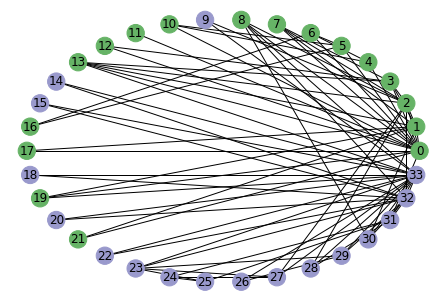

In [7]:
draw_graph(nx_g)

O código abaixo carrega o grafo sem os rótulos na biblioteca DGL. As arestas são bidirecionais.

In [9]:
src = []
dst = []
weight = []
for u, v in nx_g.edges():
    src.append(u)
    dst.append(v)

g = dgl.DGLGraph((src, dst))
g.add_edges(dst, src) 

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


Como é possível observar abaixo, o grafo agora está sem os rótulos, sendo que todos os nós são representados pela cor cinza.

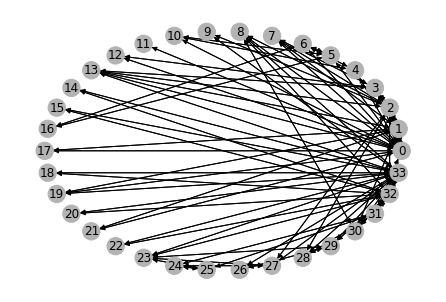

In [10]:
draw_graph(g.to_networkx())

In [11]:
print('%d nós.' % g.number_of_nodes())
print('%d arestas.' % g.number_of_edges())

34 nós.
156 arestas.


## Criando o Modelo

A classe abaixo é uma implementação de Rede Neural Convolucional para Grafos utilizando a arquitetura [GraphSearch](https://arxiv.org/abs/1706.02216). Foram utilizadas duas camadas `SAGE` e uma `ReLU` entre elas.

In [36]:
import itertools
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import SAGEConv

class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, num_classes, 'mean')
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

net = GraphSAGE(34, 16, 2)
net

GraphSAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_self): Linear(in_features=34, out_features=16, bias=True)
    (fc_neigh): Linear(in_features=34, out_features=16, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_self): Linear(in_features=16, out_features=2, bias=True)
    (fc_neigh): Linear(in_features=16, out_features=2, bias=True)
  )
)

O código abaixo extrai os labels apenas os nós 0 e 33, correspondentes ao *Mr. Hi* e ao *Officer*, respectivamente, e define como labels os valores 0 e 1. Em seguida, inicializa um vetor (*tensor*) contendo 34 elementos completamente diferentes entre si (*one-hot encoding*).

In [37]:
labeled_nodes = torch.tensor([0, 33])
labels = torch.tensor([0,1])

inputs = torch.eye(34)
inputs

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

## Treinamento

O treinamento utilizou o otimizador `Adam` e iterou em 200 épocas.

In [38]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_preds = []
epochs = 200

for epoch in range(epochs):
    preds = net(g, inputs)
    all_preds.append(preds)
    # calcula o erro (loss) apenas para os nós rotulados
    logp = F.log_softmax(preds, 1)
    loss = F.nll_loss(logp[labeled_nodes], labels)
    
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step()
    if epoch % 5 == 0:
        print('Epoch %d | Loss: %.10f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.6913655996
Epoch 5 | Loss: 0.2884444594
Epoch 10 | Loss: 0.1098585054
Epoch 15 | Loss: 0.0432334766
Epoch 20 | Loss: 0.0182397440
Epoch 25 | Loss: 0.0089189401
Epoch 30 | Loss: 0.0050862506
Epoch 35 | Loss: 0.0032848325
Epoch 40 | Loss: 0.0023511190
Epoch 45 | Loss: 0.0018228295
Epoch 50 | Loss: 0.0014979327
Epoch 55 | Loss: 0.0012802025
Epoch 60 | Loss: 0.0011236903
Epoch 65 | Loss: 0.0010072872
Epoch 70 | Loss: 0.0009130831
Epoch 75 | Loss: 0.0008348905
Epoch 80 | Loss: 0.0007688421
Epoch 85 | Loss: 0.0007120215
Epoch 90 | Loss: 0.0006628815
Epoch 95 | Loss: 0.0006191598
Epoch 100 | Loss: 0.0005805593
Epoch 105 | Loss: 0.0005455315
Epoch 110 | Loss: 0.0005140173
Epoch 115 | Loss: 0.0004853022
Epoch 120 | Loss: 0.0004588503
Epoch 125 | Loss: 0.0004338871
Epoch 130 | Loss: 0.0004096382
Epoch 135 | Loss: 0.0003860442
Epoch 140 | Loss: 0.0003641179
Epoch 145 | Loss: 0.0003427870
Epoch 150 | Loss: 0.0003219919
Epoch 155 | Loss: 0.0003022688
Epoch 160 | Loss: 0.0002843331

# Validação

Abaixo é possível verificar que após o treinamento, os elementos rotulados (0 e 33) estão em classes opostas. Em seguida é calculada a acurácia considerando todos os nós do grafo. Por fim, o grafo é desenhado, sendo que os nós verdes e azuis foram aqueles que o modelo conseguiu classificar corretamente e os nós rosa e laranjado foram classificados de maneira incorreta.

In [39]:
preds[labeled_nodes]

tensor([[ 4.3392, -4.3300],
        [-5.2812,  3.2144]], grad_fn=<IndexBackward>)

In [40]:
pred = torch.argmax(preds, axis=1)
all_labels = torch.tensor(get_labels(nx_g))
print('Accuracy', (pred == all_labels).sum().item() / len(pred))

Accuracy 0.9117647058823529


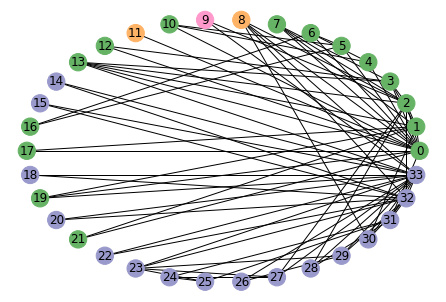

In [41]:
draw_graph(nx_g, pred)